## Read data from txt files

In [1]:
import glob
def get_data(pos_dir, negdir):
    data=[]
    targets=[]
    for directory in glob.glob(pos_dir):
        document  = open(directory, "r")
        data.append(document.read())
        targets.append(1)
        document.close() 
    for directory in glob.glob(negdir):
        document  = open(directory, "r")
        data.append(document.read())
        targets.append(0)
        document.close()
    return data, targets

In [2]:
train_data_, train_targets_=get_data("./aclImdb/train/pos/*.*", "./aclImdb/train/neg/*.*")

In [3]:
test_data_, test_targets_=get_data("./aclImdb/test/pos/*.*", "./aclImdb/test/neg/*.*")

## Split train data into actual train and validation sets

In [4]:
# Split train data into actual train and validation sets

train_split = 20000
train_data = train_data_[:train_split]
train_targets = train_targets_[:train_split]

val_data = train_data_[train_split:]
val_targets = train_targets_[train_split:]

test_data = test_data_
test_targets = test_targets_

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [5]:
# Random sample from train dataset
import random
print (train_data[random.randint(0, len(train_data) - 1)])

A young boy sees his mother getting killed and his father hanging himself. 20 years later he gets a bunch of friends together to perform an exorcism on himself so he won't turn out like his father. All the stock characters are in place: the nice couple; the "funny" guy; the tough (but sensitive) hood; the smart girl (she wears glasses--that's how we know); the nerd and two no-personality blondes. It all involves some stupid wooden statue that comes to life (don't ask) and kills people. I knew I was in trouble when, after a great opening scene, we jump to 20 years later--ALL bad horror movies do that!<br /><br />The dialogue is atrocious, the acting is bad (except for Betsy Palmer--why Betsy?) and the killings are stupid and/or unimaginative. My favorite scene is when two people are supposedly having sex and the statue knocks the guy off the bed to show he's fully dressed! A real bad, stupid incoherent horror film. Avoid at all costs.


## Let's write the tokenization function

In [6]:
# #def tokenize_n_gram(sent, n):
# n=2
# sent='Apple is looking at buying U.K. startup for $1 billion'
import spacy
import string
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def tokenize_n_gram(sent, n):
    tokens = tokenizer(sent)
    result=[]
    for i in range (0, len(tokens)-n+1):
        found_punctuation=False
        for j in range (0, n):
            if (tokens[i+j].text in punctuations):
                found_punctuation=True
                break
        if (not found_punctuation):
            result.append(tokens[i:i+n].text.lower())
    return result
#tokenize_n_gram(u'Apple is looking at buying U.K. startup for $1 billion', 2)

In [7]:
# # Let's write the tokenization function 

# import spacy
# import string

# # Load English tokenizer, tagger, parser, NER and word vectors
# tokenizer = spacy.load('en_core_web_sm')
# punctuations = string.punctuation

# # lowercase and remove punctuation
# def tokenize(sent):
#     tokens = tokenizer(sent)
#     return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# # Example
# tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
# print (tokens)

In [8]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset(dataset, n):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for i, sample in enumerate(dataset):
        if i>0 and i % 1000 == 0:
            print ("{} documents finished".format(i))
        tokens = tokenize_n_gram(sample, n)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

#val set tokens
def Tokenizing_data(val_data, test_data, train_data, n):
    print ("{}_gram:".format(n))
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(val_data, n)
    pkl.dump(val_data_tokens, open("./pickle_file/val_data_tokens_{}_gram.p".format(n), "wb"))

    #test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset(test_data, n)
    pkl.dump(test_data_tokens, open("./pickle_file/test_data_tokens_{}_gram.p".format(n), "wb"))

    #train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(train_data, n)
    pkl.dump(train_data_tokens, open("./pickle_file/train_data_tokens_{}_gram.p".format(n), "wb"))
    pkl.dump(all_train_tokens, open("./pickle_file/all_train_tokens_{}_gram.p".format(n), "wb"))

In [9]:
#Tokenizing_data(val_data, test_data, train_data, 1)

## convert token to id in the dataset

In [10]:
def load_data (n):
    train_data_tokens = pkl.load(open("./pickle_file_n_gram/train_data_tokens_{}_gram.p".format(n), "rb"))
    all_train_tokens = pkl.load(open("./pickle_file_n_gram/all_train_tokens_{}_gram.p".format(n), "rb"))

    val_data_tokens = pkl.load(open("./pickle_file_n_gram/val_data_tokens_{}_gram.p".format(n), "rb"))
    test_data_tokens = pkl.load(open("./pickle_file_n_gram/test_data_tokens_{}_gram.p".format(n), "rb"))
    return train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens

In [11]:
train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens=load_data (1)

In [12]:
from collections import Counter

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [13]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5662 ; token plot.<br
Token plot.<br; token id 5662


In [14]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [15]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [16]:
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [17]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        #print (out.shape)
        out = torch.sum(out, dim=1)
        #print (out.shape)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        #print(length.view(length.size()[0],1).expand_as(out).float())
        #print (out.shape)
     
        # return logits
        out = self.linear(out.float())
        #print (out.shape)
        return out

In [18]:


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [113]:
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
def train_model(train_loader, val_loader, model, optimizer):
    training_loss=[]
    validation_accuracy =[]
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            #print(len(data_batch), len(length_batch))
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            training_loss.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                validation_accuracy.append(val_acc)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    return training_loss, validation_accuracy 

In [20]:
train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens=load_data (1)

In [21]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 61.78
Epoch: [1/10], Step: [201/625], Validation Acc: 67.52
Epoch: [1/10], Step: [301/625], Validation Acc: 84.76
Epoch: [1/10], Step: [401/625], Validation Acc: 79.44
Epoch: [1/10], Step: [501/625], Validation Acc: 75.22
Epoch: [1/10], Step: [601/625], Validation Acc: 80.34
Epoch: [2/10], Step: [101/625], Validation Acc: 85.9
Epoch: [2/10], Step: [201/625], Validation Acc: 83.98
Epoch: [2/10], Step: [301/625], Validation Acc: 80.3
Epoch: [2/10], Step: [401/625], Validation Acc: 80.12
Epoch: [2/10], Step: [501/625], Validation Acc: 74.7
Epoch: [2/10], Step: [601/625], Validation Acc: 76.98
Epoch: [3/10], Step: [101/625], Validation Acc: 78.38
Epoch: [3/10], Step: [201/625], Validation Acc: 70.4
Epoch: [3/10], Step: [301/625], Validation Acc: 76.18
Epoch: [3/10], Step: [401/625], Validation Acc: 77.52
Epoch: [3/10], Step: [501/625], Validation Acc: 77.88
Epoch: [3/10], Step: [601/625], Validation Acc: 80.66
Epoch: [4/10], Step: [101/625], 

In [108]:
! matplotlib inline 
import matplotlib.pyplot as plt
def training_loss_curve(training_loss):
    plt.figure(figsize=(12,10)) 
    plt.xlabel("Number of 100 times iteratiosn")
    plt.ylabel("CrossEntropyLoss")
    plt.plot(training_loss)
    
def validation_accuracy_curve(validation_accuracy):
    plt.figure(figsize=(12,10)) 
    plt.xlabel("Number of 100 times iterations")
    plt.ylabel("validation_accuracy")
    plt.ylim(50, 90)
    plt.plot(validation_accuracy)
    

/bin/sh: matplotlib: command not found


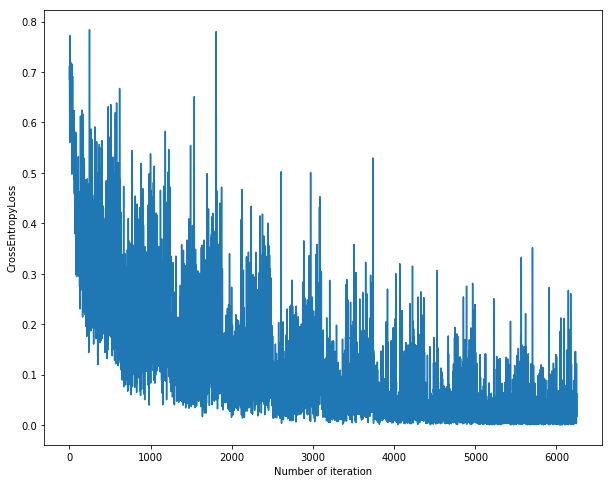

In [23]:
training_loss_curve(training_loss)

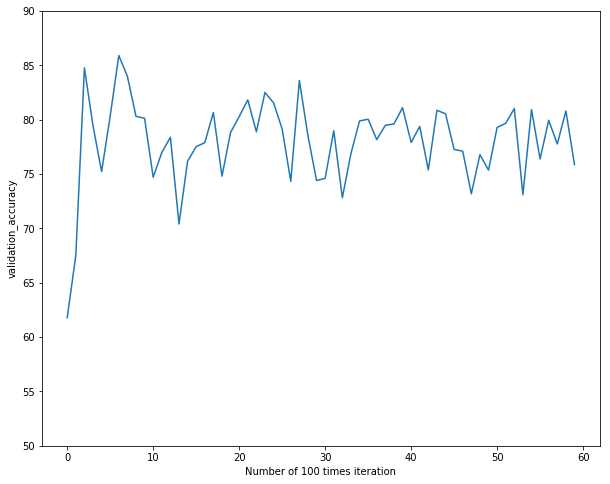

In [24]:
validation_accuracy_curve(validation_accuracy)

In [25]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 74.28
Test Acc 79.48


## Tokenization schemes of the dataset.

### stripping punctuation

In [26]:
# Let's write the tokenization function 

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize_unstripping(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens]

# Example
tokens = tokenize_unstripping(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '$', '1', 'billion']


In [27]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset_unstripping(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for i, sample in enumerate(dataset):
        if i>0 and i % 1000 == 0:
            print ("{} documents finished".format(i))
        tokens = tokenize_unstripping(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

#val set tokens
def Tokenizing_data_unstripping(val_data, test_data, train_data):
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset_unstripping(val_data)
    pkl.dump(val_data_tokens, open("./pickle_file_unstripping/val_data_tokens.p", "wb"))

    #test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset_unstripping(test_data)
    pkl.dump(test_data_tokens, open("./pickle_file_unstripping/test_data_tokens.p", "wb"))

    #train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset_unstripping(train_data)
    pkl.dump(train_data_tokens, open("./pickle_file_unstripping/train_data_tokens.p", "wb"))
    pkl.dump(all_train_tokens, open("./pickle_file_unstripping/all_train_tokens.p", "wb"))

In [28]:
#Tokenizing_data_unstripping(val_data, test_data, train_data)

In [29]:
train_data_tokens = pkl.load(open("./pickle_file_unstripping/train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("./pickle_file_unstripping/all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("./pickle_file_unstripping/val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("./pickle_file_unstripping/test_data_tokens.p", "rb"))

In [30]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100
max_vocab_size = 10000

model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 67.26
Epoch: [1/10], Step: [201/625], Validation Acc: 79.16
Epoch: [1/10], Step: [301/625], Validation Acc: 76.12
Epoch: [1/10], Step: [401/625], Validation Acc: 75.9
Epoch: [1/10], Step: [501/625], Validation Acc: 76.38
Epoch: [1/10], Step: [601/625], Validation Acc: 77.58
Epoch: [2/10], Step: [101/625], Validation Acc: 77.96
Epoch: [2/10], Step: [201/625], Validation Acc: 77.04
Epoch: [2/10], Step: [301/625], Validation Acc: 77.34
Epoch: [2/10], Step: [401/625], Validation Acc: 85.62
Epoch: [2/10], Step: [501/625], Validation Acc: 83.94
Epoch: [2/10], Step: [601/625], Validation Acc: 79.28
Epoch: [3/10], Step: [101/625], Validation Acc: 72.74
Epoch: [3/10], Step: [201/625], Validation Acc: 78.44
Epoch: [3/10], Step: [301/625], Validation Acc: 78.16
Epoch: [3/10], Step: [401/625], Validation Acc: 77.26
Epoch: [3/10], Step: [501/625], Validation Acc: 80.94
Epoch: [3/10], Step: [601/625], Validation Acc: 76.42
Epoch: [4/10], Step: [101/625

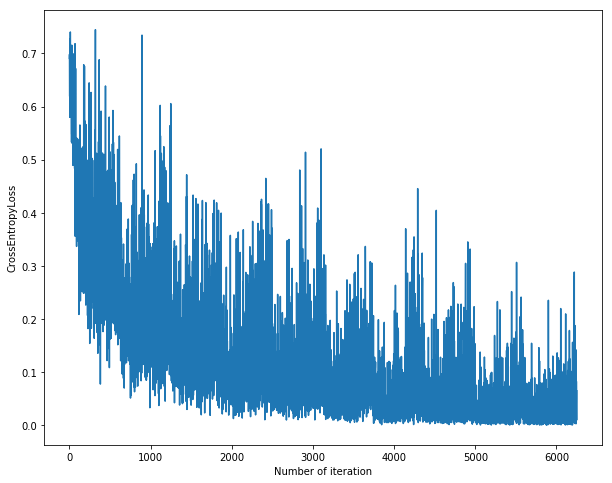

In [31]:
training_loss_curve(training_loss)

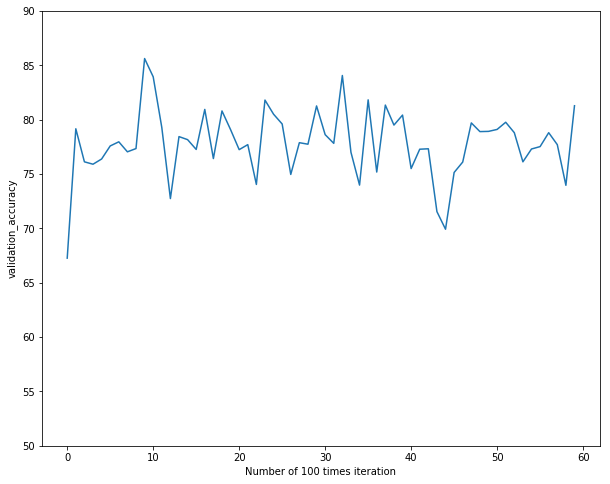

In [32]:
validation_accuracy_curve(validation_accuracy)

From these two above figures, we can see that stripping punctions has a better performance in terms of best performance. 

### wo_Lowering_Case 

In [33]:
# Let's write the tokenization function 

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize_wo_lowercase(sent):
    tokens = tokenizer(sent)
    return [token.text for token in tokens if token.text not in punctuations]

# Example
tokens = tokenize_wo_lowercase(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '1', 'billion']


In [34]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset_wo_lowering_case(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for i, sample in enumerate(dataset):
        if i>0 and i % 1000 == 0:
            print ("{} documents finished".format(i))
        tokens = tokenize_wo_lowercase(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

#val set tokens
def Tokenizing_data_wo_lowering_case(val_data, test_data, train_data):
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset_wo_lowering_case(val_data)
    pkl.dump(val_data_tokens, open("./pickle_file_wo_lowering_case/val_data_tokens.p", "wb"))

    #test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset_wo_lowering_case(test_data)
    pkl.dump(test_data_tokens, open("./pickle_file_wo_lowering_case/test_data_tokens.p", "wb"))

    #train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset_wo_lowering_case(train_data)
    pkl.dump(train_data_tokens, open("./pickle_file_wo_lowering_case/train_data_tokens.p", "wb"))
    pkl.dump(all_train_tokens, open("./pickle_file_wo_lowering_case/all_train_tokens.p", "wb"))

In [35]:
#Tokenizing_data_wo_lowering_case(val_data, test_data, train_data)

In [36]:
train_data_tokens = pkl.load(open("./pickle_file_wo_lowering_case/train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("./pickle_file_wo_lowering_case/all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("./pickle_file_wo_lowering_case/val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("./pickle_file_wo_lowering_case/test_data_tokens.p", "rb"))

In [37]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

max_vocab_size = 10000

model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 61.64
Epoch: [1/10], Step: [201/625], Validation Acc: 64.34
Epoch: [1/10], Step: [301/625], Validation Acc: 71.2
Epoch: [1/10], Step: [401/625], Validation Acc: 80.08
Epoch: [1/10], Step: [501/625], Validation Acc: 73.02
Epoch: [1/10], Step: [601/625], Validation Acc: 75.32
Epoch: [2/10], Step: [101/625], Validation Acc: 80.94
Epoch: [2/10], Step: [201/625], Validation Acc: 86.78
Epoch: [2/10], Step: [301/625], Validation Acc: 80.1
Epoch: [2/10], Step: [401/625], Validation Acc: 77.24
Epoch: [2/10], Step: [501/625], Validation Acc: 83.02
Epoch: [2/10], Step: [601/625], Validation Acc: 80.88
Epoch: [3/10], Step: [101/625], Validation Acc: 81.58
Epoch: [3/10], Step: [201/625], Validation Acc: 80.14
Epoch: [3/10], Step: [301/625], Validation Acc: 80.52
Epoch: [3/10], Step: [401/625], Validation Acc: 80.04
Epoch: [3/10], Step: [501/625], Validation Acc: 77.38
Epoch: [3/10], Step: [601/625], Validation Acc: 83.96
Epoch: [4/10], Step: [101/625]

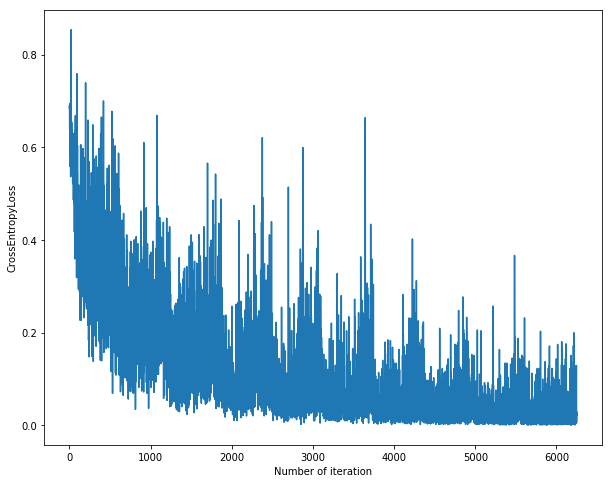

In [38]:
training_loss_curve(training_loss)

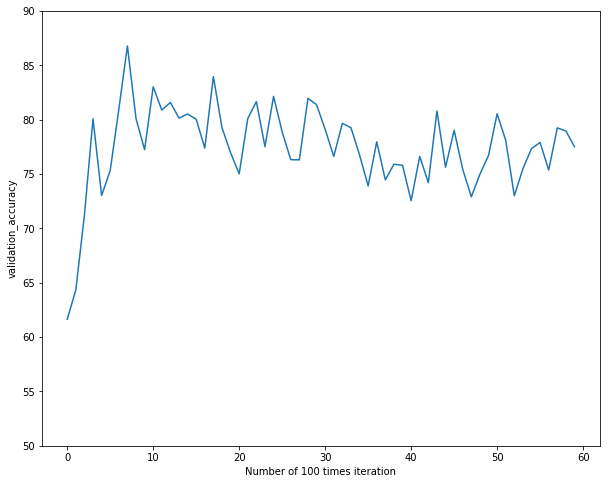

In [39]:
validation_accuracy_curve(validation_accuracy)

From these two above figures, we can see that lowering case has a better performance in terms of best performance. 

## Model hyperparameters: 

### Vary n for n-gram (n=1, 2, 3, 4)

In [40]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset(dataset, n):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for i, sample in enumerate(dataset):
        if i>0 and i % 1000 == 0:
            print ("{} documents finished".format(i))
        tokens = tokenize_n_gram(sample, n)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

#val set tokens
def Tokenizing_data(n, val_data=val_data, test_data=test_data, train_data=train_data):
    print ("{}_gram:".format(n))
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(val_data, n)
    pkl.dump(val_data_tokens, open("./pickle_file_n_gram/val_data_tokens_{}_gram.p".format(n), "wb"))

    #test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset(test_data, n)
    pkl.dump(test_data_tokens, open("./pickle_file_n_gram/test_data_tokens_{}_gram.p".format(n), "wb"))

    #train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(train_data, n)
    pkl.dump(train_data_tokens, open("./pickle_file_n_gram/train_data_tokens_{}_gram.p".format(n), "wb"))
    pkl.dump(all_train_tokens, open("./pickle_file_n_gram/all_train_tokens_{}_gram.p".format(n), "wb"))

In [41]:
# from multiprocessing import Pool

# # def f(x):
# #     return x*x

# if __name__ == '__main__':
#     with Pool(5) as p:
#         p.map(Tokenizing_data, [2, 3, 4])    

### 2-gram

In [42]:
train_data_tokens_1 = pkl.load(open("./pickle_file/train_data_tokens.p", "rb"))
all_train_tokens_1 = pkl.load(open("./pickle_file/all_train_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open("./pickle_file/val_data_tokens.p", "rb"))
test_data_tokens_1 = pkl.load(open("./pickle_file/test_data_tokens.p", "rb"))

In [43]:
train_data_tokens_2, all_train_tokens_2, val_data_tokens_2, test_data_tokens_2=load_data (2)

In [44]:
train_data_tokens = [train_data_tokens_1[i] + train_data_tokens_2[i] for i in range(len(train_data_tokens_1))]
val_data_tokens = [val_data_tokens_1[i] + val_data_tokens_2[i] for i in range(len(val_data_tokens_1))]
test_data_tokens = [test_data_tokens_1[i] + test_data_tokens_2[i] for i in range(len(test_data_tokens_1))]
all_train_tokens = all_train_tokens_1 + all_train_tokens_2

In [45]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

max_vocab_size = 10000

model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 65.2
Epoch: [1/10], Step: [201/625], Validation Acc: 76.42
Epoch: [1/10], Step: [301/625], Validation Acc: 82.1
Epoch: [1/10], Step: [401/625], Validation Acc: 67.38
Epoch: [1/10], Step: [501/625], Validation Acc: 79.98
Epoch: [1/10], Step: [601/625], Validation Acc: 74.74
Epoch: [2/10], Step: [101/625], Validation Acc: 77.78
Epoch: [2/10], Step: [201/625], Validation Acc: 74.12
Epoch: [2/10], Step: [301/625], Validation Acc: 75.44
Epoch: [2/10], Step: [401/625], Validation Acc: 82.44
Epoch: [2/10], Step: [501/625], Validation Acc: 77.82
Epoch: [2/10], Step: [601/625], Validation Acc: 74.06
Epoch: [3/10], Step: [101/625], Validation Acc: 78.74
Epoch: [3/10], Step: [201/625], Validation Acc: 78.56
Epoch: [3/10], Step: [301/625], Validation Acc: 75.42
Epoch: [3/10], Step: [401/625], Validation Acc: 79.42
Epoch: [3/10], Step: [501/625], Validation Acc: 78.46
Epoch: [3/10], Step: [601/625], Validation Acc: 79.02
Epoch: [4/10], Step: [101/625]

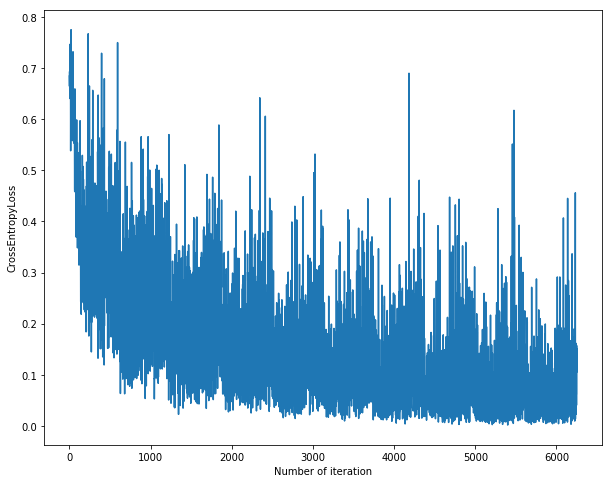

In [46]:
training_loss_curve(training_loss)

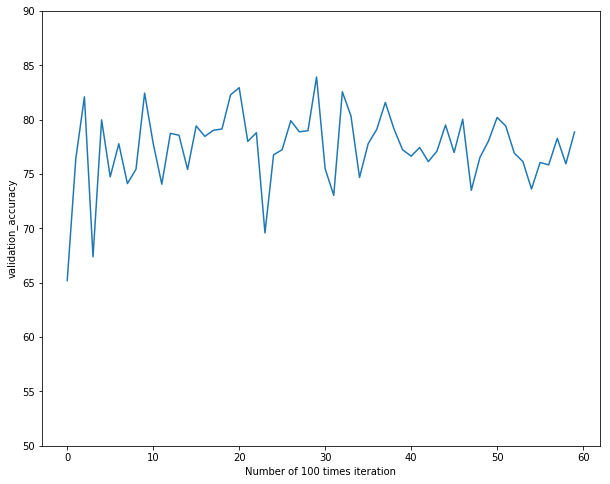

In [47]:
validation_accuracy_curve(validation_accuracy)

### 3-gram 

In [48]:
train_data_tokens_1 = pkl.load(open("./pickle_file/train_data_tokens.p", "rb"))
all_train_tokens_1 = pkl.load(open("./pickle_file/all_train_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open("./pickle_file/val_data_tokens.p", "rb"))
test_data_tokens_1 = pkl.load(open("./pickle_file/test_data_tokens.p", "rb"))

In [49]:
train_data_tokens_2, all_train_tokens_2, val_data_tokens_2, test_data_tokens_2=load_data (2)

In [50]:
train_data_tokens_3, all_train_tokens_3, val_data_tokens_3, test_data_tokens_3=load_data (3)

In [51]:
train_data_tokens = [train_data_tokens_1[i] + train_data_tokens_2[i]+train_data_tokens_3[i] for i in range(len(train_data_tokens_1))]
val_data_tokens = [val_data_tokens_1[i] + val_data_tokens_2[i] +val_data_tokens_3[i] for i in range(len(val_data_tokens_1))]
test_data_tokens = [test_data_tokens_1[i] + test_data_tokens_2[i]+test_data_tokens_3[i] for i in range(len(test_data_tokens_1))]
all_train_tokens = all_train_tokens_1 + all_train_tokens_2 +all_train_tokens_3

In [52]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

max_vocab_size = 10000

model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 51.4
Epoch: [1/10], Step: [201/625], Validation Acc: 76.24
Epoch: [1/10], Step: [301/625], Validation Acc: 77.9
Epoch: [1/10], Step: [401/625], Validation Acc: 82.04
Epoch: [1/10], Step: [501/625], Validation Acc: 78.24
Epoch: [1/10], Step: [601/625], Validation Acc: 76.94
Epoch: [2/10], Step: [101/625], Validation Acc: 80.7
Epoch: [2/10], Step: [201/625], Validation Acc: 79.58
Epoch: [2/10], Step: [301/625], Validation Acc: 78.24
Epoch: [2/10], Step: [401/625], Validation Acc: 81.6
Epoch: [2/10], Step: [501/625], Validation Acc: 83.88
Epoch: [2/10], Step: [601/625], Validation Acc: 77.16
Epoch: [3/10], Step: [101/625], Validation Acc: 73.16
Epoch: [3/10], Step: [201/625], Validation Acc: 79.68
Epoch: [3/10], Step: [301/625], Validation Acc: 73.02
Epoch: [3/10], Step: [401/625], Validation Acc: 77.3
Epoch: [3/10], Step: [501/625], Validation Acc: 81.6
Epoch: [3/10], Step: [601/625], Validation Acc: 77.54
Epoch: [4/10], Step: [101/625], Va

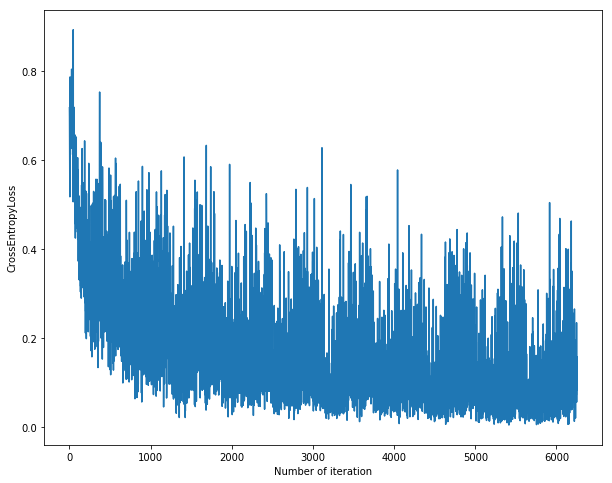

In [53]:
training_loss_curve(training_loss)

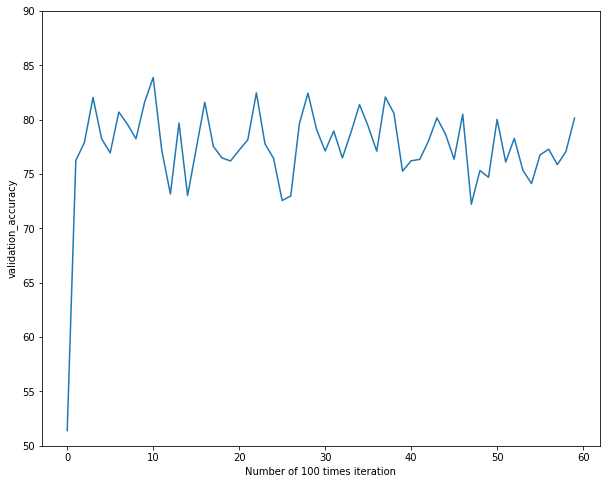

In [54]:
validation_accuracy_curve(validation_accuracy)

### 4-gram

In [55]:
train_data_tokens_1 = pkl.load(open("./pickle_file/train_data_tokens.p", "rb"))
all_train_tokens_1 = pkl.load(open("./pickle_file/all_train_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open("./pickle_file/val_data_tokens.p", "rb"))
test_data_tokens_1 = pkl.load(open("./pickle_file/test_data_tokens.p", "rb"))

In [56]:
train_data_tokens_2, all_train_tokens_2, val_data_tokens_2, test_data_tokens_2=load_data (2)

In [57]:
train_data_tokens_3, all_train_tokens_3, val_data_tokens_3, test_data_tokens_3=load_data (3)

In [58]:
train_data_tokens_4, all_train_tokens_4, val_data_tokens_4, test_data_tokens_4=load_data (4)

In [59]:
train_data_tokens = [train_data_tokens_1[i] + train_data_tokens_2[i]+train_data_tokens_3[i]+train_data_tokens_4[i] for i in range(len(train_data_tokens_1))]
val_data_tokens = [val_data_tokens_1[i] + val_data_tokens_2[i] +val_data_tokens_3[i]+val_data_tokens_4[i] for i in range(len(val_data_tokens_1))]
test_data_tokens = [test_data_tokens_1[i] + test_data_tokens_2[i]+test_data_tokens_3[i]+test_data_tokens_4[i] for i in range(len(test_data_tokens_1))]
all_train_tokens = all_train_tokens_1 + all_train_tokens_2 +all_train_tokens_3+all_train_tokens_4

In [60]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

max_vocab_size = 10000

model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 61.98
Epoch: [1/10], Step: [201/625], Validation Acc: 56.04
Epoch: [1/10], Step: [301/625], Validation Acc: 70.06
Epoch: [1/10], Step: [401/625], Validation Acc: 65.88
Epoch: [1/10], Step: [501/625], Validation Acc: 79.36
Epoch: [1/10], Step: [601/625], Validation Acc: 73.9
Epoch: [2/10], Step: [101/625], Validation Acc: 74.18
Epoch: [2/10], Step: [201/625], Validation Acc: 75.38
Epoch: [2/10], Step: [301/625], Validation Acc: 78.82
Epoch: [2/10], Step: [401/625], Validation Acc: 77.26
Epoch: [2/10], Step: [501/625], Validation Acc: 72.46
Epoch: [2/10], Step: [601/625], Validation Acc: 81.7
Epoch: [3/10], Step: [101/625], Validation Acc: 81.68
Epoch: [3/10], Step: [201/625], Validation Acc: 78.3
Epoch: [3/10], Step: [301/625], Validation Acc: 74.66
Epoch: [3/10], Step: [401/625], Validation Acc: 79.36
Epoch: [3/10], Step: [501/625], Validation Acc: 75.46
Epoch: [3/10], Step: [601/625], Validation Acc: 76.18
Epoch: [4/10], Step: [101/625],

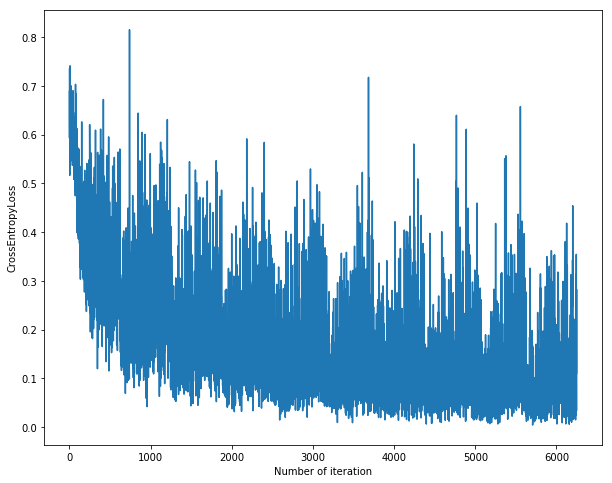

In [61]:
training_loss_curve(training_loss)

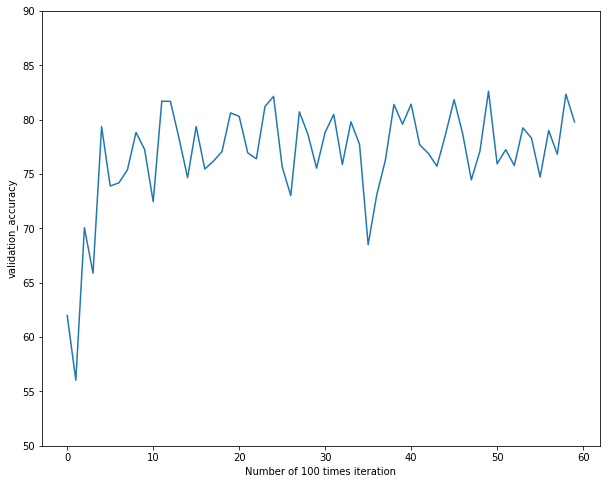

In [62]:
validation_accuracy_curve(validation_accuracy)

From thhese figures above, we choose 4-gram. 

## vocabulary size

### 20000

In [118]:
train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens=load_data (1)

In [119]:
max_vocab_size = 20000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 63.54
Epoch: [1/10], Step: [201/625], Validation Acc: 81.52
Epoch: [1/10], Step: [301/625], Validation Acc: 82.88
Epoch: [1/10], Step: [401/625], Validation Acc: 81.5
Epoch: [1/10], Step: [501/625], Validation Acc: 84.0
Epoch: [1/10], Step: [601/625], Validation Acc: 81.2
Epoch: [2/10], Step: [101/625], Validation Acc: 84.64
Epoch: [2/10], Step: [201/625], Validation Acc: 83.38
Epoch: [2/10], Step: [301/625], Validation Acc: 81.62
Epoch: [2/10], Step: [401/625], Validation Acc: 79.6
Epoch: [2/10], Step: [501/625], Validation Acc: 82.04
Epoch: [2/10], Step: [601/625], Validation Acc: 78.08
Epoch: [3/10], Step: [101/625], Validation Acc: 82.5
Epoch: [3/10], Step: [201/625], Validation Acc: 73.62
Epoch: [3/10], Step: [301/625], Validation Acc: 85.12
Epoch: [3/10], Step: [401/625], Validation Acc: 79.72
Epoch: [3/10], Step: [501/625], Validation Acc: 85.7
Epoch: [3/10], Step: [601/625], Validation Acc: 77.96
Epoch: [4/10], Step: [101/625], Va

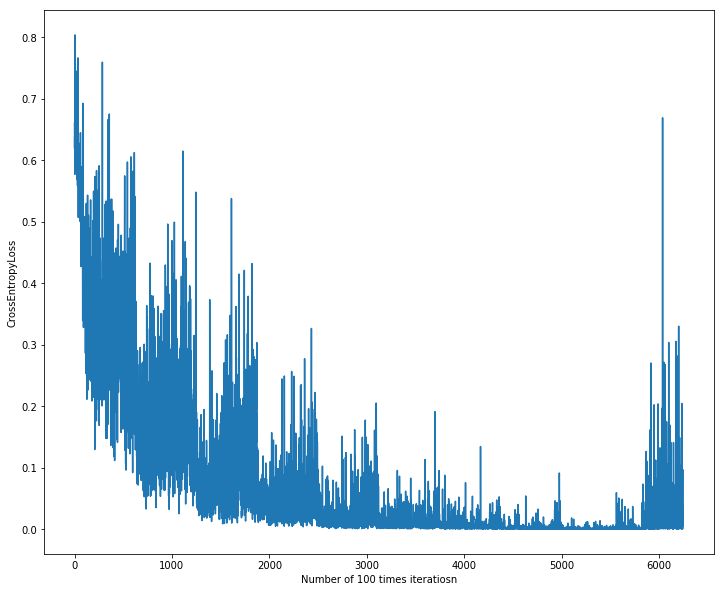

In [120]:
training_loss_curve(training_loss)

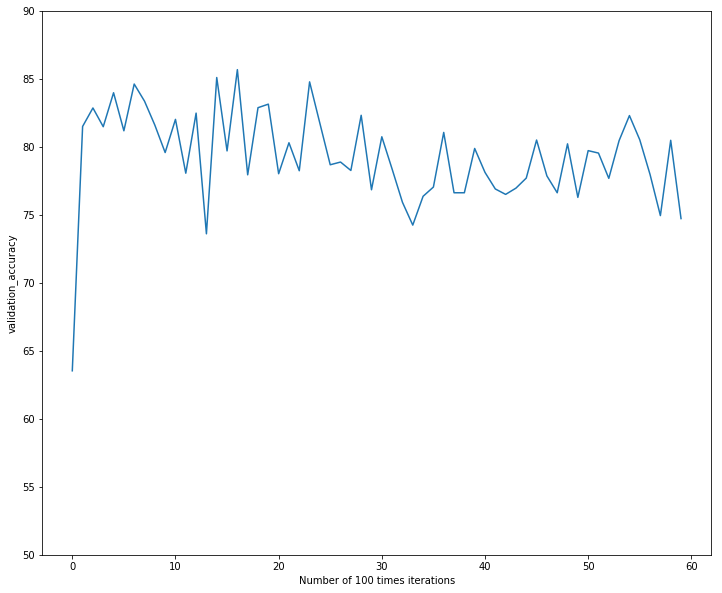

In [121]:
validation_accuracy_curve(validation_accuracy)

### 50000

In [122]:
train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens=load_data (1)

In [123]:
max_vocab_size = 50000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 100

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 62.6
Epoch: [1/10], Step: [201/625], Validation Acc: 73.48
Epoch: [1/10], Step: [301/625], Validation Acc: 78.82
Epoch: [1/10], Step: [401/625], Validation Acc: 83.4
Epoch: [1/10], Step: [501/625], Validation Acc: 84.6
Epoch: [1/10], Step: [601/625], Validation Acc: 83.5
Epoch: [2/10], Step: [101/625], Validation Acc: 81.04
Epoch: [2/10], Step: [201/625], Validation Acc: 84.26
Epoch: [2/10], Step: [301/625], Validation Acc: 78.28
Epoch: [2/10], Step: [401/625], Validation Acc: 77.28
Epoch: [2/10], Step: [501/625], Validation Acc: 81.94
Epoch: [2/10], Step: [601/625], Validation Acc: 82.52
Epoch: [3/10], Step: [101/625], Validation Acc: 84.96
Epoch: [3/10], Step: [201/625], Validation Acc: 75.14
Epoch: [3/10], Step: [301/625], Validation Acc: 82.7
Epoch: [3/10], Step: [401/625], Validation Acc: 80.44
Epoch: [3/10], Step: [501/625], Validation Acc: 78.3
Epoch: [3/10], Step: [601/625], Validation Acc: 82.4
Epoch: [4/10], Step: [101/625], Val

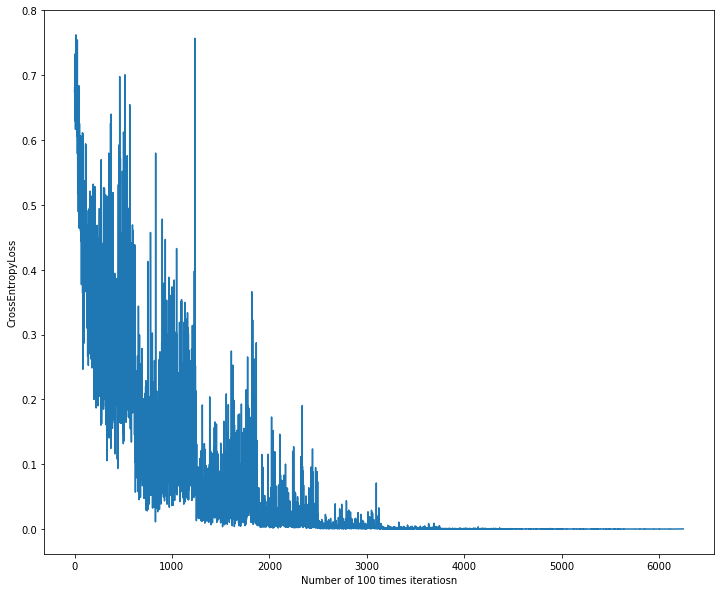

In [124]:
training_loss_curve(training_loss)

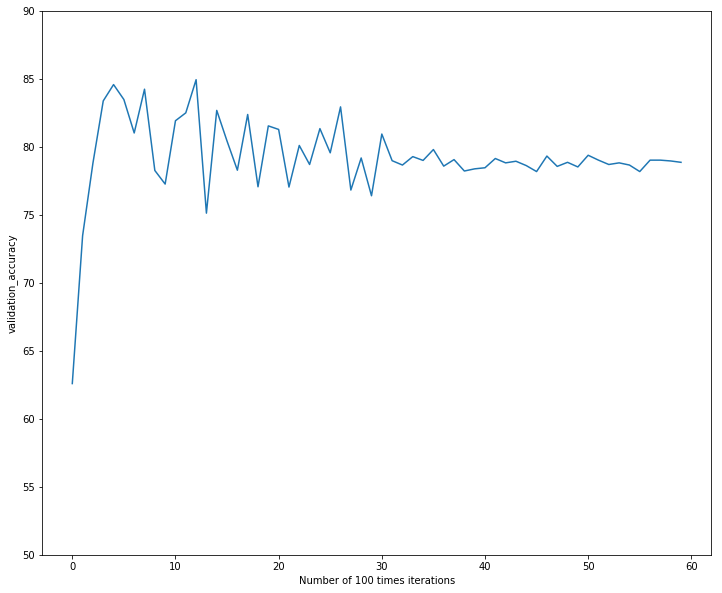

In [125]:
validation_accuracy_curve(validation_accuracy)

From these figures above, we choose vocabulary size = 10000

### embedding size

### 200

In [127]:
max_vocab_size = 10000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 200

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 59.24
Epoch: [1/10], Step: [201/625], Validation Acc: 77.96
Epoch: [1/10], Step: [301/625], Validation Acc: 76.7
Epoch: [1/10], Step: [401/625], Validation Acc: 68.9
Epoch: [1/10], Step: [501/625], Validation Acc: 76.06
Epoch: [1/10], Step: [601/625], Validation Acc: 72.82
Epoch: [2/10], Step: [101/625], Validation Acc: 74.3
Epoch: [2/10], Step: [201/625], Validation Acc: 71.28
Epoch: [2/10], Step: [301/625], Validation Acc: 74.38
Epoch: [2/10], Step: [401/625], Validation Acc: 85.16
Epoch: [2/10], Step: [501/625], Validation Acc: 79.3
Epoch: [2/10], Step: [601/625], Validation Acc: 78.74
Epoch: [3/10], Step: [101/625], Validation Acc: 77.34
Epoch: [3/10], Step: [201/625], Validation Acc: 82.58
Epoch: [3/10], Step: [301/625], Validation Acc: 77.92
Epoch: [3/10], Step: [401/625], Validation Acc: 81.14
Epoch: [3/10], Step: [501/625], Validation Acc: 75.68
Epoch: [3/10], Step: [601/625], Validation Acc: 80.94
Epoch: [4/10], Step: [101/625], 

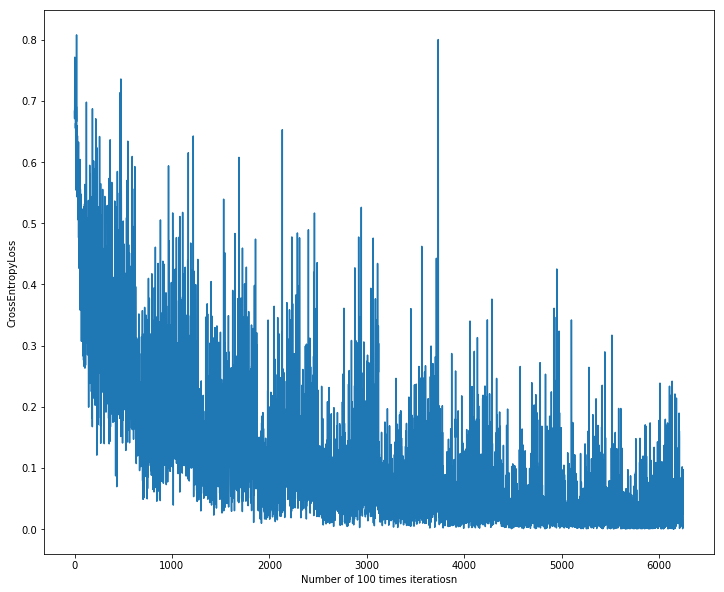

In [128]:
training_loss_curve(training_loss)

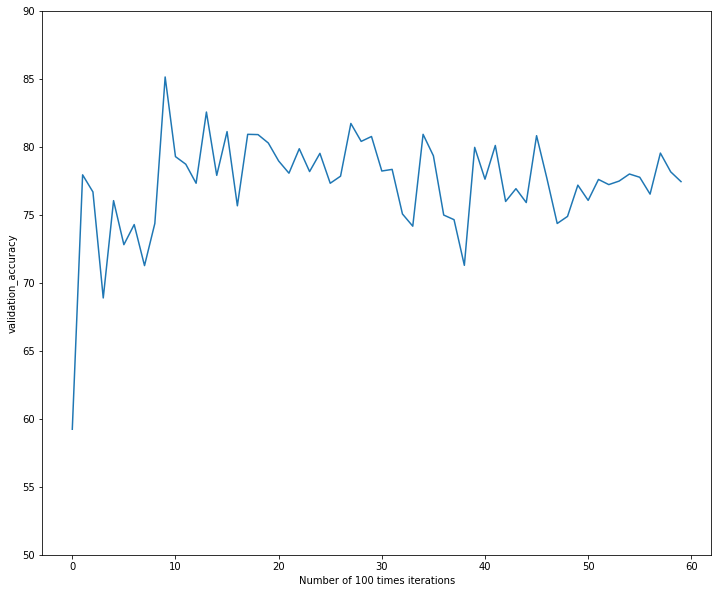

In [129]:
validation_accuracy_curve(validation_accuracy)

### 500

In [130]:
max_vocab_size = 10000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 500

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 73.26
Epoch: [1/10], Step: [201/625], Validation Acc: 84.9
Epoch: [1/10], Step: [301/625], Validation Acc: 76.1
Epoch: [1/10], Step: [401/625], Validation Acc: 78.68
Epoch: [1/10], Step: [501/625], Validation Acc: 75.92
Epoch: [1/10], Step: [601/625], Validation Acc: 85.28
Epoch: [2/10], Step: [101/625], Validation Acc: 83.76
Epoch: [2/10], Step: [201/625], Validation Acc: 86.04
Epoch: [2/10], Step: [301/625], Validation Acc: 82.88
Epoch: [2/10], Step: [401/625], Validation Acc: 83.94
Epoch: [2/10], Step: [501/625], Validation Acc: 77.64
Epoch: [2/10], Step: [601/625], Validation Acc: 82.98
Epoch: [3/10], Step: [101/625], Validation Acc: 81.14
Epoch: [3/10], Step: [201/625], Validation Acc: 84.52
Epoch: [3/10], Step: [301/625], Validation Acc: 79.56
Epoch: [3/10], Step: [401/625], Validation Acc: 72.74
Epoch: [3/10], Step: [501/625], Validation Acc: 83.48
Epoch: [3/10], Step: [601/625], Validation Acc: 77.54
Epoch: [4/10], Step: [101/625]

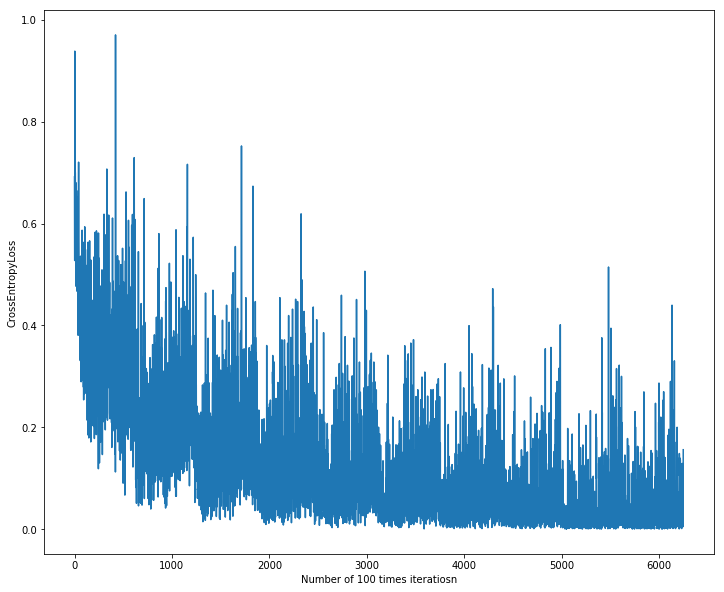

In [131]:
training_loss_curve(training_loss)

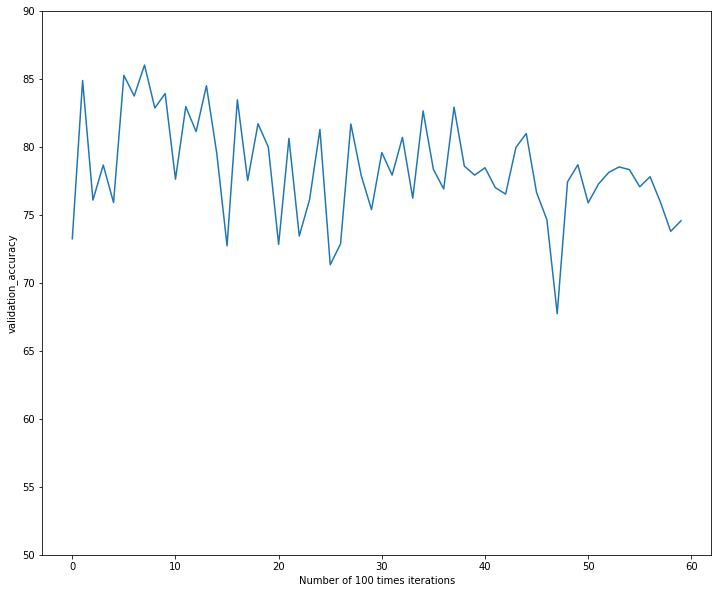

In [132]:
validation_accuracy_curve(validation_accuracy)

From figures above, we choose embed size = 100

### Optimization hyperparameters: 
#### Optimizer: SGD

In [98]:
max_vocab_size = 10000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.01
num_epochs = 10 # number epoch to train
emb_dim = 500

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss, validation_accuracy = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 0.0
Epoch: [1/10], Step: [201/625], Validation Acc: 0.04
Epoch: [1/10], Step: [301/625], Validation Acc: 0.1
Epoch: [1/10], Step: [401/625], Validation Acc: 1.48
Epoch: [1/10], Step: [501/625], Validation Acc: 0.36
Epoch: [1/10], Step: [601/625], Validation Acc: 4.94
Epoch: [2/10], Step: [101/625], Validation Acc: 3.86
Epoch: [2/10], Step: [201/625], Validation Acc: 8.28
Epoch: [2/10], Step: [301/625], Validation Acc: 7.14
Epoch: [2/10], Step: [401/625], Validation Acc: 17.26
Epoch: [2/10], Step: [501/625], Validation Acc: 18.68
Epoch: [2/10], Step: [601/625], Validation Acc: 23.44
Epoch: [3/10], Step: [101/625], Validation Acc: 23.8
Epoch: [3/10], Step: [201/625], Validation Acc: 15.96
Epoch: [3/10], Step: [301/625], Validation Acc: 15.36
Epoch: [3/10], Step: [401/625], Validation Acc: 13.66
Epoch: [3/10], Step: [501/625], Validation Acc: 18.94
Epoch: [3/10], Step: [601/625], Validation Acc: 18.52
Epoch: [4/10], Step: [101/625], Validati

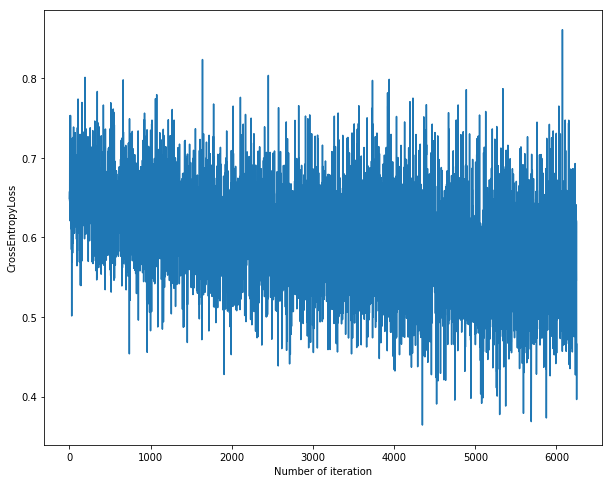

In [99]:
training_loss_curve(training_loss)

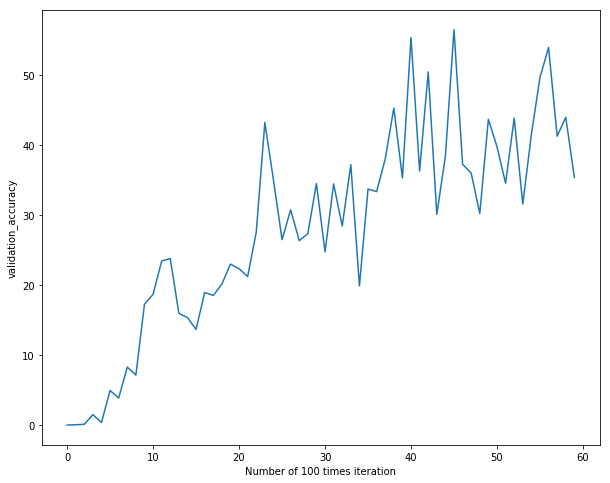

In [100]:
def validation_accuracy_curve_(validation_accuracy):
    plt.figure(figsize=(10,8)) 
    plt.xlabel("Number of 100 times iteration")
    plt.ylabel("validation_accuracy")
    #plt.ylim(50, 90)
    plt.plot(validation_accuracy)
validation_accuracy_curve_(validation_accuracy)

Choose Adam since it can converge must faster than SGD with monmentum

### Learning Rate 

In [133]:
max_vocab_size = 50000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.005
num_epochs = 10 # number epoch to train
emb_dim = 100

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss_005, validation_accuracy_005 = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 53.22
Epoch: [1/10], Step: [201/625], Validation Acc: 60.1
Epoch: [1/10], Step: [301/625], Validation Acc: 73.02
Epoch: [1/10], Step: [401/625], Validation Acc: 75.36
Epoch: [1/10], Step: [501/625], Validation Acc: 78.76
Epoch: [1/10], Step: [601/625], Validation Acc: 79.8
Epoch: [2/10], Step: [101/625], Validation Acc: 80.88
Epoch: [2/10], Step: [201/625], Validation Acc: 74.98
Epoch: [2/10], Step: [301/625], Validation Acc: 82.86
Epoch: [2/10], Step: [401/625], Validation Acc: 86.68
Epoch: [2/10], Step: [501/625], Validation Acc: 75.84
Epoch: [2/10], Step: [601/625], Validation Acc: 79.08
Epoch: [3/10], Step: [101/625], Validation Acc: 80.0
Epoch: [3/10], Step: [201/625], Validation Acc: 80.62
Epoch: [3/10], Step: [301/625], Validation Acc: 79.68
Epoch: [3/10], Step: [401/625], Validation Acc: 79.7
Epoch: [3/10], Step: [501/625], Validation Acc: 81.72
Epoch: [3/10], Step: [601/625], Validation Acc: 81.88
Epoch: [4/10], Step: [101/625], 

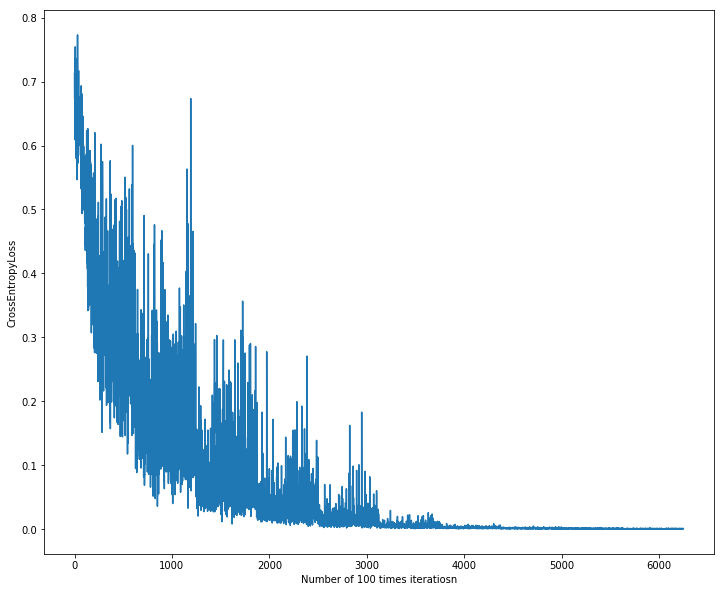

In [134]:
training_loss_curve(training_loss_005)

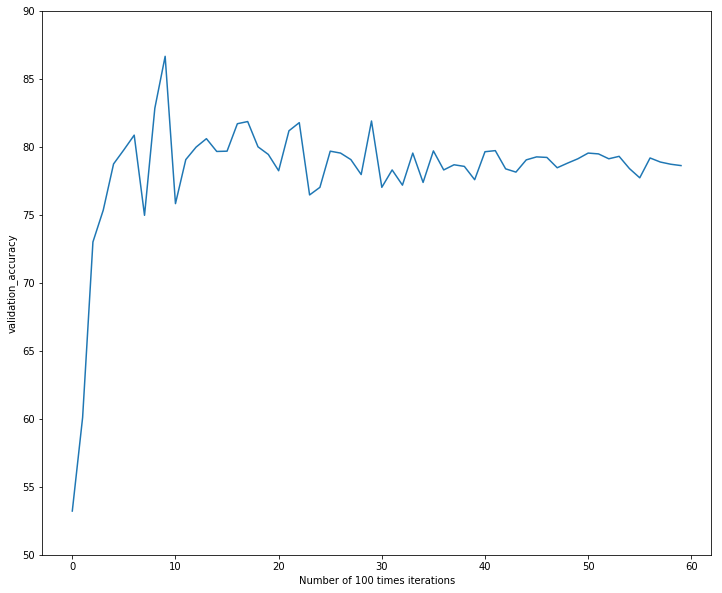

In [135]:
 validation_accuracy_curve(validation_accuracy_005)

In [136]:
max_vocab_size = 50000
# # save index 0 for unk and 1 for pad
# PAD_IDX = 0
# UNK_IDX = 1

learning_rate = 0.02
num_epochs = 10 # number epoch to train
emb_dim = 100

token2id, id2token = build_vocab(all_train_tokens)

# Criterion and Optimizer
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)



train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)


BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



training_loss_02, validation_accuracy_02 = train_model(train_loader, val_loader, model, optimizer)

Epoch: [1/10], Step: [101/625], Validation Acc: 82.9
Epoch: [1/10], Step: [201/625], Validation Acc: 79.94
Epoch: [1/10], Step: [301/625], Validation Acc: 82.08
Epoch: [1/10], Step: [401/625], Validation Acc: 77.72
Epoch: [1/10], Step: [501/625], Validation Acc: 85.5
Epoch: [1/10], Step: [601/625], Validation Acc: 76.06
Epoch: [2/10], Step: [101/625], Validation Acc: 80.62
Epoch: [2/10], Step: [201/625], Validation Acc: 83.34
Epoch: [2/10], Step: [301/625], Validation Acc: 76.5
Epoch: [2/10], Step: [401/625], Validation Acc: 81.58
Epoch: [2/10], Step: [501/625], Validation Acc: 69.58
Epoch: [2/10], Step: [601/625], Validation Acc: 78.6
Epoch: [3/10], Step: [101/625], Validation Acc: 79.7
Epoch: [3/10], Step: [201/625], Validation Acc: 84.02
Epoch: [3/10], Step: [301/625], Validation Acc: 77.38
Epoch: [3/10], Step: [401/625], Validation Acc: 86.24
Epoch: [3/10], Step: [501/625], Validation Acc: 73.14
Epoch: [3/10], Step: [601/625], Validation Acc: 76.96
Epoch: [4/10], Step: [101/625], V

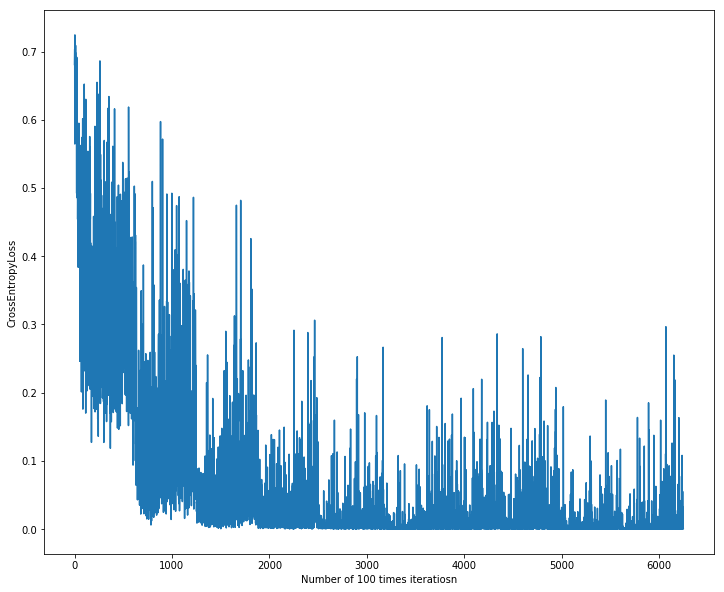

In [137]:
training_loss_curve(training_loss_02)

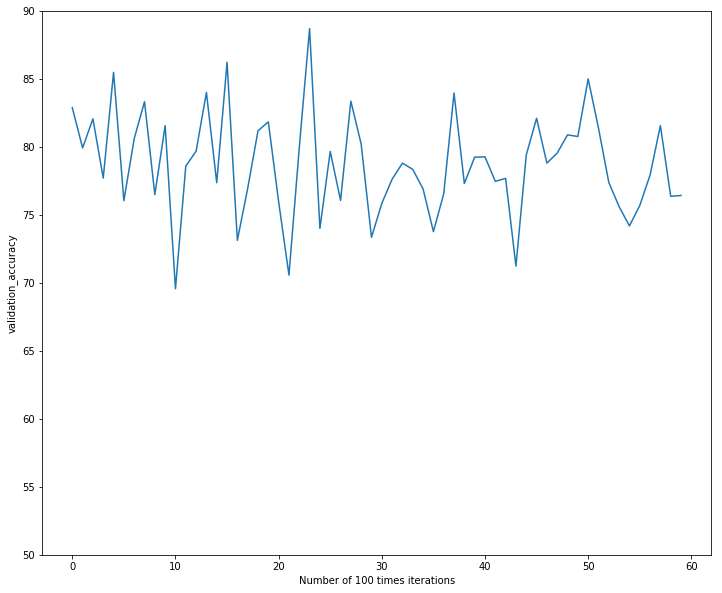

In [138]:
 validation_accuracy_curve(validation_accuracy_02)

In [139]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 84.42
Test Acc 80.196


### Examples

In [159]:
correct = 0
for data, lengths, labels in test_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        data=data_batch
        prediction=predicted.eq(labels.view_as(predicted))
        break

In [166]:
print (test_data[0], test_targets[0])

Based on an actual story, John Boorman shows the struggle of an American doctor, whose husband and son were murdered and she was continually plagued with her loss. A holiday to Burma with her sister seemed like a good idea to get away from it all, but when her passport was stolen in Rangoon, she could not leave the country with her sister, and was forced to stay back until she could get I.D. papers from the American embassy. To fill in a day before she could fly out, she took a trip into the countryside with a tour guide. "I tried finding something in those stone statues, but nothing stirred in me. I was stone myself." <br /><br />Suddenly all hell broke loose and she was caught in a political revolt. Just when it looked like she had escaped and safely boarded a train, she saw her tour guide get beaten and shot. In a split second she decided to jump from the moving train and try to rescue him, with no thought of herself. Continually her life was in danger. <br /><br />Here is a woman w

In [167]:
print (test_data[2], test_targets[2])

I really like this show. It has drama, romance, and comedy all rolled into one. I am 28 and I am a married mother, so I can identify both with Lorelei's and Rory's experiences in the show. I have been watching mostly the repeats on the Family Channel lately, so I am not up-to-date on what is going on now. I think females would like this show more than males, but I know some men out there would enjoy it! I really like that is an hour long and not a half hour, as th hour seems to fly by when I am watching it! Give it a chance if you have never seen the show! I think Lorelei and Luke are my favorite characters on the show though, mainly because of the way they are with one another. How could you not see something was there (or take that long to see it I guess I should say)? <br /><br />Happy viewing! 1


In [168]:
print (test_data[3], test_targets[3])

This is the best 3-D experience Disney has at their themeparks. This is certainly better than their original 1960's acid-trip film that was in it's place, is leagues better than "Honey I Shrunk The Audience" (and far more fun), barely squeaks by the MuppetVision 3-D movie at Disney-MGM and can even beat the original 3-D "Movie Experience" Captain EO. This film relives some of Disney's greatest musical hits from Aladdin, The Little Mermaid, and others, and brought a smile to my face throughout the entire show. This is a totally kid-friendly movie too, unlike "Honey..." and has more effects than the spectacular "MuppetVision" 1


In [169]:
print (test_data[1], test_targets[1])

This is a gem. As a Film Four production - the anticipated quality was indeed delivered. Shot with great style that reminded me some Errol Morris films, well arranged and simply gripping. It's long yet horrifying to the point it's excruciating. We know something bad happened (one can guess by the lack of participation of a person in the interviews) but we are compelled to see it, a bit like a car accident in slow motion. The story spans most conceivable aspects and unlike some documentaries did not try and refrain from showing the grimmer sides of the stories, as also dealing with the guilt of the people Don left behind him, wondering why they didn't stop him in time. It took me a few hours to get out of the melancholy that gripped me after seeing this very-well made documentary. 1


In [170]:
print (test_data[4], test_targets[4])

Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent horror A Tale of Two Sisters. The second and third - and now fourth too - have all been Park Chan Wook's movies, namely Oldboy, Sympathy for Lady Vengeance), and now Thirst. <br /><br />Park kinda reminds me of Quentin Tarantino with his irreverence towards convention. All his movies are shocking, but not in a gratuitous sense. It's more like he shows us what we don't expect to see - typically situations that go radically against society's morals, like incest or a libidinous, blood-sucking, yet devout priest. He's also quite artistically-inclined with regards to cinematography, and his movies are among the more gorgeous that I've seen.<br /><br />Thirst is all that - being about said priest and the repressed, conscience-less woman he falls for - and more. It's horror, drama, and even comedy, as Park disarms his audience with many inappropriate yet humorous situations. As such, this might be 

In [171]:
print (test_data[7], test_targets[7])

There is no need for me to repeat the synopsis rendered by Glenn. The black and white rendition is even more powerful in portraying the bleakness of country village life at that time. The deep measure of friendship shown by Babette toward the two elderly sisters touches the heart strings. The supporting cast is excellent and their performances superb, it would not be fair to single out any one character since the entire story depends on the cast as a whole. I cannot put my finger exactly on why I rate this movie so highly since I am not a professional critic; individual viewers may or may not agree with my rating since enjoyment of this type of movie is always in the eye of the beholder. 1


In [164]:
prediction

tensor([[0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.uint8)

In [163]:
[id2token[x] for x in data[1]]

['this',
 'is',
 'a',
 'gem',
 'as',
 'a',
 'film',
 'four',
 'production',
 'the',
 'anticipated',
 'quality',
 'was',
 'indeed',
 'delivered',
 'shot',
 'with',
 'great',
 'style',
 'that',
 'reminded',
 'me',
 'some',
 'errol',
 'morris',
 'films',
 'well',
 'arranged',
 'and',
 'simply',
 'gripping',
 'it',
 "'s",
 'long',
 'yet',
 'horrifying',
 'to',
 'the',
 'point',
 'it',
 "'s",
 'excruciating',
 'we',
 'know',
 'something',
 'bad',
 'happened',
 'one',
 'can',
 'guess',
 'by',
 'the',
 'lack',
 'of',
 'participation',
 'of',
 'a',
 'person',
 'in',
 'the',
 'interviews',
 'but',
 'we',
 'are',
 'compelled',
 'to',
 'see',
 'it',
 'a',
 'bit',
 'like',
 'a',
 'car',
 'accident',
 'in',
 'slow',
 'motion',
 'the',
 'story',
 'spans',
 'most',
 'conceivable',
 'aspects',
 'and',
 'unlike',
 'some',
 'documentaries',
 'did',
 'not',
 'try',
 'and',
 'refrain',
 'from',
 'showing',
 'the',
 'grimmer',
 'sides',
 'of',
 'the',
 'stories',
 'as',
 'also',
 'dealing',
 'with',
 'the'